In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm, gamma, multivariate_normal
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split

In [2]:
# Load data
filename = 'new_york_bicycles2.csv'

df = pd.read_csv(filename)

In [3]:
X = np.array(df['Brooklyn Bridge'])
y = np.array(df['Manhattan Bridge'])

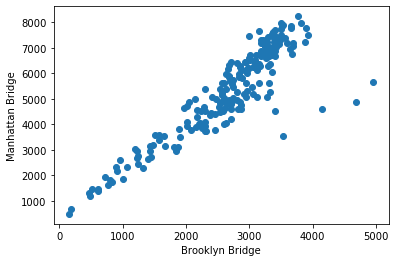

In [4]:
# Plot the data
plt.figure()
plt.scatter(X, y)
plt.xlabel('Brooklyn Bridge')
plt.ylabel('Manhattan Bridge')
plt.show()

In [5]:
def phi(x):
    n_samples = len(x)
    return np.matrix([np.ones(n_samples), x]).T

In [6]:
test_size = 0.90

x_train, x_val, y_train, y_val = train_test_split(phi(X), y, test_size=test_size, random_state=42)

y_train = np.matrix(y_train).T
y_val = np.matrix(y_val).T

In [7]:
def log_prob(y, X, w, alpha, beta, a0, b0):
    n = X.shape[0]
    d = X.shape[1]
    lp = gamma.logpdf(beta, a=a0, scale=1/b0) + multivariate_normal.logpdf(w, mean=np.zeros(d), cov=1/alpha*np.identity(d) )
    for i in range(n):
        lp += norm.logpdf(y[i], loc=np.dot(w.T, X[i, :].T), scale=np.sqrt(1/beta))
    return lp[0, 0]

## Gibbs sampler

In [97]:
def test():
    X = np.array([
        [1,2,3],
        [4,5,6],
        [7,8,9],
        [0,1,2],
    ])

    y = np.array([[1,2,3,4]]).T
    
    print(X.shape)
    print(y.shape)
    print(X)
    print(y)
    print(X*y)
    
test()

(4, 3)
(4, 1)
[[1 2 3]
 [4 5 6]
 [7 8 9]
 [0 1 2]]
[[1]
 [2]
 [3]
 [4]]
[[ 1  2  3]
 [ 8 10 12]
 [21 24 27]
 [ 0  4  8]]


In [88]:
# Gibbs sampler
def sample_w(y, X, alpha, beta):
    d = X.shape[1]
    S = np.linalg.inv(alpha*np.identity(d) + beta*X.T*X)
    m = np.array(S*(beta*X.T*y)).reshape(d,)
    return multivariate_normal.rvs(mean=m, cov=S)

def sample_beta(y, X, w, a0, b0):
    n = X.shape[0]
    a = a0 + n/2
    sq_error = 0
    for i in range(n):
        sq_error += (y[i] - np.dot(w.T, X[i, :].T))**2
    b = b0 + sq_error/2
    return gamma.rvs(a=a, scale=1/b)


In [103]:
def sample_w(y, X, alpha, beta):
    d = X.shape[1]
    S = np.linalg.inv(alpha*np.identity(d) + beta*X.T*X)
    m = np.array(S*(beta*X.T*y)).reshape(d,)
    
    print('X: ', X.shape)
    print('y: ', y.shape)
    X = np.array(X)
    y = np.array(y)
    print(m)
    print(S@(beta*X*y.reshape(-1,1)).sum(0))
    print()
    
    return multivariate_normal.rvs(mean=m, cov=S)

def sample_beta(y, X, w, a0, b0):
    n = X.shape[0]
    a = a0 + n/2            
    p = y.ravel()-w@X.T
    return gamma.rvs(a=a, scale=1/(0.5*p@p.T+b0))

np.random.seed(1)

# Hyperparameters
alpha = 1
a0 = 0.01
b0 = 0.01

# Initialization of the parameters
beta_init = 1

n_iters = 1000
burnin = int(n_iters/2)

beta = beta_init

d = x_train.shape[1]

w_samples_gibbs = np.zeros((n_iters, d))
beta_samples_gibbs = np.zeros(n_iters)

lps_gibbs = np.zeros(n_iters)

for i in range(n_iters):
        w = sample_w(y_train, x_train, alpha, beta)
        beta = sample_beta(y_train, x_train, w, a0, b0)
        
        w_samples_gibbs[i, :] = w
        beta_samples_gibbs[i] = beta
        
        lp = log_prob(y_train, x_train, w, alpha, beta, a0, b0)
        lps_gibbs[i] = lp

X:  (21, 2)
y:  (21, 1)
[-388.3835603     2.12193648]
[[-388.3835603     2.12193648]]

X:  (21, 2)
y:  (21, 1)
[-4.36760629e-04  1.98258391e+00]
[[-4.36760629e-04  1.98258391e+00]]

X:  (21, 2)
y:  (21, 1)
[-6.46166127e-04  1.98354924e+00]
[[-6.46166127e-04  1.98354924e+00]]

X:  (21, 2)
y:  (21, 1)
[-1.25522492e-03  1.98516991e+00]
[[-1.25522492e-03  1.98516991e+00]]

X:  (21, 2)
y:  (21, 1)
[-3.70472262e-04  1.98219811e+00]
[[-3.70472262e-04  1.98219811e+00]]

X:  (21, 2)
y:  (21, 1)
[-4.27111772e-04  1.98253063e+00]
[[-4.27111772e-04  1.98253063e+00]]

X:  (21, 2)
y:  (21, 1)
[-5.09698476e-04  1.98295872e+00]
[[-5.09698476e-04  1.98295872e+00]]

X:  (21, 2)
y:  (21, 1)
[-9.70857342e-04  1.98456192e+00]
[[-9.70857342e-04  1.98456192e+00]]

X:  (21, 2)
y:  (21, 1)
[-5.19219872e-04  1.98300428e+00]
[[-5.19219872e-04  1.98300428e+00]]

X:  (21, 2)
y:  (21, 1)
[-3.23389290e-04  1.98189309e+00]
[[-3.23389290e-04  1.98189309e+00]]

X:  (21, 2)
y:  (21, 1)
[-3.59120393e-04  1.98212710e+00]


X:  (21, 2)
y:  (21, 1)
[-1.25505592e-03  1.98516960e+00]
[[-1.25505592e-03  1.98516960e+00]]

X:  (21, 2)
y:  (21, 1)
[2.35320142e-04 1.97329606e+00]
[[2.35320142e-04 1.97329606e+00]]

X:  (21, 2)
y:  (21, 1)
[-2.62241026e-04  1.98145138e+00]
[[-2.62241026e-04  1.98145138e+00]]

X:  (21, 2)
y:  (21, 1)
[-4.87057109e-04  1.98284739e+00]
[[-4.87057109e-04  1.98284739e+00]]

X:  (21, 2)
y:  (21, 1)
[-7.77108867e-04  1.98401190e+00]
[[-7.77108867e-04  1.98401190e+00]]

X:  (21, 2)
y:  (21, 1)
[-6.83547790e-04  1.98369038e+00]
[[-6.83547790e-04  1.98369038e+00]]

X:  (21, 2)
y:  (21, 1)
[-6.29640558e-04  1.98348428e+00]
[[-6.29640558e-04  1.98348428e+00]]

X:  (21, 2)
y:  (21, 1)
[-3.54539063e-04  1.98209800e+00]
[[-3.54539063e-04  1.98209800e+00]]

X:  (21, 2)
y:  (21, 1)
[-4.94764890e-04  1.98288577e+00]
[[-4.94764890e-04  1.98288577e+00]]

X:  (21, 2)
y:  (21, 1)
[-5.74009980e-04  1.98325302e+00]
[[-5.74009980e-04  1.98325302e+00]]

X:  (21, 2)
y:  (21, 1)
[-5.96549266e-04  1.98334914e+

X:  (21, 2)
y:  (21, 1)
[-5.03181113e-04  1.98292711e+00]
[[-5.03181113e-04  1.98292711e+00]]

X:  (21, 2)
y:  (21, 1)
[-2.46151236e-04  1.98132544e+00]
[[-2.46151236e-04  1.98132544e+00]]

X:  (21, 2)
y:  (21, 1)
[-2.76692683e-04  1.98156088e+00]
[[-2.76692683e-04  1.98156088e+00]]

X:  (21, 2)
y:  (21, 1)
[-6.77310757e-04  1.98366737e+00]
[[-6.77310757e-04  1.98366737e+00]]

X:  (21, 2)
y:  (21, 1)
[-8.51392227e-04  1.98423921e+00]
[[-8.51392227e-04  1.98423921e+00]]

X:  (21, 2)
y:  (21, 1)
[-1.49523279e-04  1.98046610e+00]
[[-1.49523279e-04  1.98046610e+00]]

X:  (21, 2)
y:  (21, 1)
[-2.41210313e-04  1.98128589e+00]
[[-2.41210313e-04  1.98128589e+00]]

X:  (21, 2)
y:  (21, 1)
[-4.0796589e-04  1.9824221e+00]
[[-4.0796589e-04  1.9824221e+00]]

X:  (21, 2)
y:  (21, 1)
[-1.41954517e-03  1.98544623e+00]
[[-1.41954517e-03  1.98544623e+00]]

X:  (21, 2)
y:  (21, 1)
[-4.85910977e-05  1.97932411e+00]
[[-4.85910977e-05  1.97932411e+00]]

X:  (21, 2)
y:  (21, 1)
[-5.36187810e-04  1.98308371e+

X:  (21, 2)
y:  (21, 1)
[-1.19432493e-04  1.98015593e+00]
[[-1.19432493e-04  1.98015593e+00]]

X:  (21, 2)
y:  (21, 1)
[1.26344482e-04 1.97635035e+00]
[[1.26344482e-04 1.97635035e+00]]

X:  (21, 2)
y:  (21, 1)
[5.29457082e-05 1.97780190e+00]
[[5.29457082e-05 1.97780190e+00]]

X:  (21, 2)
y:  (21, 1)
[2.13507834e-04 1.97402384e+00]
[[2.13507834e-04 1.97402384e+00]]

X:  (21, 2)
y:  (21, 1)
[-4.90355028e-04  1.98286387e+00]
[[-4.90355028e-04  1.98286387e+00]]

X:  (21, 2)
y:  (21, 1)
[-2.72521155e-06  1.97869296e+00]
[[-2.72521155e-06  1.97869296e+00]]

X:  (21, 2)
y:  (21, 1)
[-6.07100912e-04  1.98339299e+00]
[[-6.07100912e-04  1.98339299e+00]]

X:  (21, 2)
y:  (21, 1)
[-4.89403876e-04  1.98285913e+00]
[[-4.89403876e-04  1.98285913e+00]]

X:  (21, 2)
y:  (21, 1)
[-4.69090929e-04  1.98275592e+00]
[[-4.69090929e-04  1.98275592e+00]]

X:  (21, 2)
y:  (21, 1)
[-1.57434117e-04  1.98054393e+00]
[[-1.57434117e-04  1.98054393e+00]]

X:  (21, 2)
y:  (21, 1)
[-1.63219767e-04  1.98059992e+00]
[[-1

X:  (21, 2)
y:  (21, 1)
[-8.95442565e-04  1.98436390e+00]
[[-8.95442565e-04  1.98436390e+00]]

X:  (21, 2)
y:  (21, 1)
[-1.29743076e-03  1.98524526e+00]
[[-1.29743076e-03  1.98524526e+00]]

X:  (21, 2)
y:  (21, 1)
[-9.26115545e-04  1.98444668e+00]
[[-9.26115545e-04  1.98444668e+00]]

X:  (21, 2)
y:  (21, 1)
[-4.60029645e-04  1.98270870e+00]
[[-4.60029645e-04  1.98270870e+00]]

X:  (21, 2)
y:  (21, 1)
[2.01941265e-04 1.97438227e+00]
[[2.01941265e-04 1.97438227e+00]]

X:  (21, 2)
y:  (21, 1)
[-3.54047625e-04  1.98209486e+00]
[[-3.54047625e-04  1.98209486e+00]]

X:  (21, 2)
y:  (21, 1)
[-1.49182326e-03  1.98555455e+00]
[[-1.49182326e-03  1.98555455e+00]]

X:  (21, 2)
y:  (21, 1)
[-8.94221396e-04  1.98436053e+00]
[[-8.94221396e-04  1.98436053e+00]]

X:  (21, 2)
y:  (21, 1)
[-4.27601489e-04  1.98253336e+00]
[[-4.27601489e-04  1.98253336e+00]]

X:  (21, 2)
y:  (21, 1)
[-5.32759012e-04  1.98306784e+00]
[[-5.32759012e-04  1.98306784e+00]]

X:  (21, 2)
y:  (21, 1)
[-4.31686482e-04  1.98255601e+

X:  (21, 2)
y:  (21, 1)
[-6.80759997e-04  1.98368012e+00]
[[-6.80759997e-04  1.98368012e+00]]

X:  (21, 2)
y:  (21, 1)
[-6.23687420e-04  1.98346047e+00]
[[-6.23687420e-04  1.98346047e+00]]

X:  (21, 2)
y:  (21, 1)
[-6.85950191e-04  1.98369919e+00]
[[-6.85950191e-04  1.98369919e+00]]

X:  (21, 2)
y:  (21, 1)
[1.03464749e-04 1.97684291e+00]
[[1.03464749e-04 1.97684291e+00]]

X:  (21, 2)
y:  (21, 1)
[-1.05149145e-03  1.98475458e+00]
[[-1.05149145e-03  1.98475458e+00]]

X:  (21, 2)
y:  (21, 1)
[-8.75593062e-04  1.98430859e+00]
[[-8.75593062e-04  1.98430859e+00]]

X:  (21, 2)
y:  (21, 1)
[-4.21955951e-04  1.98250178e+00]
[[-4.21955951e-04  1.98250178e+00]]

X:  (21, 2)
y:  (21, 1)
[-4.30637511e-04  1.98255021e+00]
[[-4.30637511e-04  1.98255021e+00]]

X:  (21, 2)
y:  (21, 1)
[-4.96416419e-05  1.97933763e+00]
[[-4.96416419e-05  1.97933763e+00]]

X:  (21, 2)
y:  (21, 1)
[1.48669034e-04 1.97582830e+00]
[[1.48669034e-04 1.97582830e+00]]

X:  (21, 2)
y:  (21, 1)
[-6.24439413e-06  1.97874439e+00]


X:  (21, 2)
y:  (21, 1)
[-2.40339642e-04  1.98127887e+00]
[[-2.40339642e-04  1.98127887e+00]]

X:  (21, 2)
y:  (21, 1)
[-1.33114463e-04  1.98029982e+00]
[[-1.33114463e-04  1.98029982e+00]]

X:  (21, 2)
y:  (21, 1)
[-2.41720231e-04  1.98128999e+00]
[[-2.41720231e-04  1.98128999e+00]]

X:  (21, 2)
y:  (21, 1)
[-7.61424015e-04  1.98396091e+00]
[[-7.61424015e-04  1.98396091e+00]]

X:  (21, 2)
y:  (21, 1)
[-4.54379156e-04  1.98267887e+00]
[[-4.54379156e-04  1.98267887e+00]]

X:  (21, 2)
y:  (21, 1)
[-6.27771710e-04  1.98347683e+00]
[[-6.27771710e-04  1.98347683e+00]]

X:  (21, 2)
y:  (21, 1)
[-9.33333551e-04  1.98446570e+00]
[[-9.33333551e-04  1.98446570e+00]]

X:  (21, 2)
y:  (21, 1)
[-5.21781316e-04  1.98301641e+00]
[[-5.21781316e-04  1.98301641e+00]]

X:  (21, 2)
y:  (21, 1)
[-3.38918260e-04  1.98199681e+00]
[[-3.38918260e-04  1.98199681e+00]]

X:  (21, 2)
y:  (21, 1)
[-5.99343550e-04  1.98336083e+00]
[[-5.99343550e-04  1.98336083e+00]]

X:  (21, 2)
y:  (21, 1)
[-2.67263710e-04  1.981489

X:  (21, 2)
y:  (21, 1)
[-1.49612559e-03  1.98556077e+00]
[[-1.49612559e-03  1.98556077e+00]]

X:  (21, 2)
y:  (21, 1)
[-9.95234694e-04  1.98462212e+00]
[[-9.95234694e-04  1.98462212e+00]]

X:  (21, 2)
y:  (21, 1)
[-6.84456994e-04  1.98369372e+00]
[[-6.84456994e-04  1.98369372e+00]]

X:  (21, 2)
y:  (21, 1)
[-6.92129349e-04  1.98372170e+00]
[[-6.92129349e-04  1.98372170e+00]]

X:  (21, 2)
y:  (21, 1)
[-1.41722185e-03  1.98544262e+00]
[[-1.41722185e-03  1.98544262e+00]]

X:  (21, 2)
y:  (21, 1)
[-6.65840474e-04  1.98362450e+00]
[[-6.65840474e-04  1.98362450e+00]]

X:  (21, 2)
y:  (21, 1)
[-4.59078121e-04  1.98270369e+00]
[[-4.59078121e-04  1.98270369e+00]]

X:  (21, 2)
y:  (21, 1)
[-1.10339362e-03  1.98486938e+00]
[[-1.10339362e-03  1.98486938e+00]]

X:  (21, 2)
y:  (21, 1)
[-3.33141711e-04  1.98195860e+00]
[[-3.33141711e-04  1.98195860e+00]]

X:  (21, 2)
y:  (21, 1)
[-3.38810642e-04  1.98199610e+00]
[[-3.38810642e-04  1.98199610e+00]]

X:  (21, 2)
y:  (21, 1)
[-6.70302192e-04  1.983641

X:  (21, 2)
y:  (21, 1)
[-9.49738139e-04  1.98450831e+00]
[[-9.49738139e-04  1.98450831e+00]]

X:  (21, 2)
y:  (21, 1)
[-1.05917443e-03  1.98477200e+00]
[[-1.05917443e-03  1.98477200e+00]]

X:  (21, 2)
y:  (21, 1)
[-1.38394594e-03  1.98539009e+00]
[[-1.38394594e-03  1.98539009e+00]]

X:  (21, 2)
y:  (21, 1)
[3.04117984e-05 1.97818112e+00]
[[3.04117984e-05 1.97818112e+00]]

X:  (21, 2)
y:  (21, 1)
[-2.11811088e-04  1.98104143e+00]
[[-2.11811088e-04  1.98104143e+00]]

X:  (21, 2)
y:  (21, 1)
[-8.59435663e-04  1.98426251e+00]
[[-8.59435663e-04  1.98426251e+00]]

X:  (21, 2)
y:  (21, 1)
[-9.80277642e-04  1.98458539e+00]
[[-9.80277642e-04  1.98458539e+00]]

X:  (21, 2)
y:  (21, 1)
[-6.01020837e-04  1.98336781e+00]
[[-6.01020837e-04  1.98336781e+00]]

X:  (21, 2)
y:  (21, 1)
[-1.21781269e-05  1.97882992e+00]
[[-1.21781269e-05  1.97882992e+00]]

X:  (21, 2)
y:  (21, 1)
[-3.65287883e-04  1.98216587e+00]
[[-3.65287883e-04  1.98216587e+00]]

X:  (21, 2)
y:  (21, 1)
[-7.11749881e-04  1.98379185e+

X:  (21, 2)
y:  (21, 1)
[-3.94761561e-04  1.98234500e+00]
[[-3.94761561e-04  1.98234500e+00]]

X:  (21, 2)
y:  (21, 1)
[-8.02717060e-04  1.98409284e+00]
[[-8.02717060e-04  1.98409284e+00]]

X:  (21, 2)
y:  (21, 1)
[-3.14096930e-04  1.98182947e+00]
[[-3.14096930e-04  1.98182947e+00]]

X:  (21, 2)
y:  (21, 1)
[-3.13722773e-04  1.98182688e+00]
[[-3.13722773e-04  1.98182688e+00]]

X:  (21, 2)
y:  (21, 1)
[-1.27894192e-03  1.98521265e+00]
[[-1.27894192e-03  1.98521265e+00]]

X:  (21, 2)
y:  (21, 1)
[-2.82465210e-04  1.98160369e+00]
[[-2.82465210e-04  1.98160369e+00]]

X:  (21, 2)
y:  (21, 1)
[-3.71278954e-04  1.98220309e+00]
[[-3.71278954e-04  1.98220309e+00]]

X:  (21, 2)
y:  (21, 1)
[-5.37894612e-04  1.98309157e+00]
[[-5.37894612e-04  1.98309157e+00]]

X:  (21, 2)
y:  (21, 1)
[-2.52103287e-04  1.98137254e+00]
[[-2.52103287e-04  1.98137254e+00]]

X:  (21, 2)
y:  (21, 1)
[-4.80074159e-04  1.98281217e+00]
[[-4.80074159e-04  1.98281217e+00]]

X:  (21, 2)
y:  (21, 1)
[-9.49722078e-04  1.984508

X:  (21, 2)
y:  (21, 1)
[-8.06664202e-04  1.98410506e+00]
[[-8.06664202e-04  1.98410506e+00]]

X:  (21, 2)
y:  (21, 1)
[-3.45166622e-04  1.98203765e+00]
[[-3.45166622e-04  1.98203765e+00]]

X:  (21, 2)
y:  (21, 1)
[-8.36348933e-04  1.98419498e+00]
[[-8.36348933e-04  1.98419498e+00]]

X:  (21, 2)
y:  (21, 1)
[-5.14815232e-04  1.98298329e+00]
[[-5.14815232e-04  1.98298329e+00]]

X:  (21, 2)
y:  (21, 1)
[-1.65535131e-03  1.98577491e+00]
[[-1.65535131e-03  1.98577491e+00]]

X:  (21, 2)
y:  (21, 1)
[-6.79348561e-04  1.98367491e+00]
[[-6.79348561e-04  1.98367491e+00]]

X:  (21, 2)
y:  (21, 1)
[-7.75730306e-04  1.98400746e+00]
[[-7.75730306e-04  1.98400746e+00]]

X:  (21, 2)
y:  (21, 1)
[-1.28188776e-03  1.98521789e+00]
[[-1.28188776e-03  1.98521789e+00]]

X:  (21, 2)
y:  (21, 1)
[-2.9844801e-04  1.9817196e+00]
[[-2.9844801e-04  1.9817196e+00]]

X:  (21, 2)
y:  (21, 1)
[-2.44027494e-04  1.98130849e+00]
[[-2.44027494e-04  1.98130849e+00]]

X:  (21, 2)
y:  (21, 1)
[-5.04938023e-04  1.98293566e+

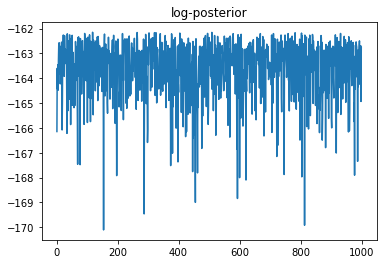

In [60]:
# Plot log-posterior probabilities
start = 1 # Ignore this many iterations from the start
# Reason: Sometimes the initial values are so bad that the remaining ones form a line
# So to get better visualisation of the remaining ones, we may sometimes use starts > 0

plt.plot(range(start, n_iters), lps_gibbs[start:])
plt.title('log-posterior')
plt.show()

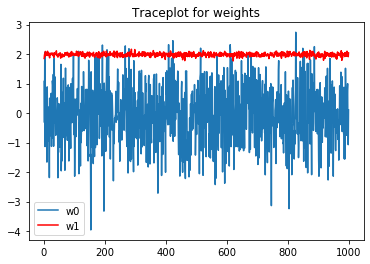

In [61]:
# Traceplots for weights
plt.plot(range(start, n_iters), w_samples_gibbs[start:, 0], label='w0')
plt.plot(range(start, n_iters), w_samples_gibbs[start:, 1], c='r', label='w1')
plt.title('Traceplot for weights')
plt.legend()
plt.show()

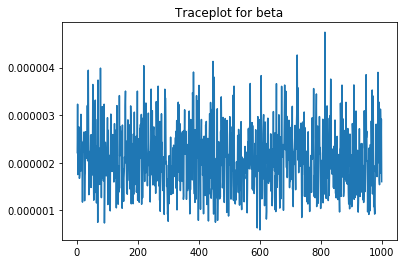

In [62]:
# Traceplots for beta
plt.plot(range(start, n_iters), beta_samples_gibbs[start:])
plt.title('Traceplot for beta')
plt.show()

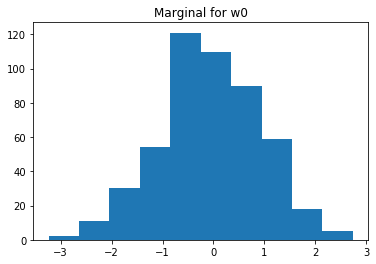

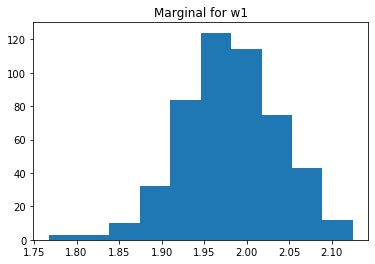

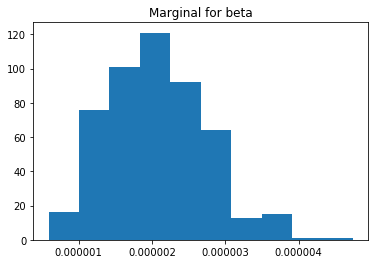

In [63]:
# Plot the marginal distributions
plt.hist(w_samples_gibbs[burnin:, 0])
plt.title('Marginal for w0')
plt.show()

plt.hist(w_samples_gibbs[burnin:, 1])
plt.title('Marginal for w1')
plt.show()

plt.hist(beta_samples_gibbs[burnin:])
plt.title('Marginal for beta')
plt.show()

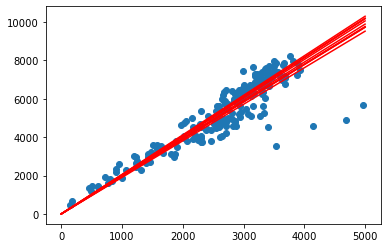

In [64]:
# Plot some functions from posterior to see whether things make sense
x = np.linspace(0, 5000, 51)
x_t = phi(x)

n_functions = 10
thinning = 50

for i in range(n_functions):
#     y_pred = np.dot(w_samples_gibbs[int(burnin + (i-1)*thinning), :], x_t.T)
    y_pred = np.dot(w_samples_gibbs[int(burnin + (i-1)*thinning), :], x_t.T)
    plt.plot(x, y_pred.reshape(-1, 1), c='r')
    
plt.scatter(X, y)
plt.show()
        

## Metropolis-Hastings

In [ ]:
def proposal(w, beta, sigma2=1, t=0.5):
    d = w.shape[0]
    w_new = w + multivariate_normal.rvs(cov=sigma2*np.identity(d))
    
    r = np.random.uniform(t, 1)
    s = np.random.uniform()
    if s < 0.5:
        beta_new = r*beta
    else:
        beta_new = 1/r*beta
    
    return w_new, beta_new

In [ ]:
np.random.seed()

# Hyperparameters
alpha = 1
a0 = 0.01
b0 = 0.01

# Parameters for the proposal distribution
sigma2 = 0.0005
t = 0.005

# Initialization of the parameters
w_init = np.array([0,0])
beta_init = 1

n_iters = 5000
burnin = int(n_iters/2)

beta = beta_init
w = w_init

d = x_train.shape[1]

w_samples_mh = np.zeros((n_iters, d))
beta_samples_mh = np.zeros(n_iters)

lps_mh = np.zeros(n_iters)

lp = log_prob(y_train, x_train, w_init, alpha, beta_init, a0, b0)

accept_count = 0

for i in range(n_iters):
    w_new, beta_new = proposal(w, beta, sigma2=sigma2, t=t)
    lp_new = log_prob(y_train, x_train, w_new, alpha, beta_new, a0, b0)
    A = np.min([1, np.exp(lp_new - lp)])
    r = np.random.rand()
    if r < A:
        w = w_new
        beta = beta_new
        lp = lp_new
        accept_count += 1
    w_samples_mh[i, :] = w
    beta_samples_mh[i] = beta
    lps_mh[i] = lp
    
print('Acceptance ratio= %s' % (accept_count/n_iters))

In [ ]:
# Plot log-posterior probabilities
start = 100 # Ignore this many iterations from the start
# Reason: Sometimes the initial values are so bad that the remaining ones form a line
# So to get better visualisation of the remaining ones, we may sometimes use starts > 0

plt.plot(range(start, n_iters), lps_mh[start:])
plt.title('log-posterior')
plt.show()

In [ ]:
# Traceplots for weights
plt.plot(range(start, n_iters), w_samples_mh[start:, 0], label='w0')
plt.plot(range(start, n_iters), w_samples_mh[start:, 1], c='r', label='w1')
plt.title('Traceplot for weights')
plt.legend()
plt.show()

In [ ]:
# Traceplots for beta
plt.plot(range(start, n_iters), beta_samples_mh[start:])
plt.title('Traceplot for beta')
plt.show()

In [ ]:
# Plot the marginal distributions
plt.hist(w_samples_mh[burnin:, 0])
plt.title('Marginal for w0')
plt.show()

plt.hist(w_samples_mh[burnin:, 1])
plt.title('Marginal for w1')
plt.show()

plt.hist(beta_samples_mh[burnin:])
plt.title('Marginal for beta')
plt.show()

In [ ]:
# Plot some functions from posterior to see whether things make sense
x = np.linspace(0, 5000, 51)
x_t = phi(x)

n_functions = 10
thinning = 100

for i in range(n_functions):
    y_pred = np.dot(w_samples_mh[int(burnin + (i-1)*thinning), :], x_t.T)
    plt.plot(x, y_pred.reshape(-1, 1), c='r')
    
plt.scatter(X, y)
plt.show()
        